# Transfer Learning for Computer Vision Tutorial

Based on the tutorial: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [ ]:
NAME = 'transfer_learning'
SAVE_PATH = f'data/test/train/{NAME}-checkpoint.pth'
REPORT_PATH = f'data/test/train/{NAME}-report.pdf'
DATA_PATH = 'data/hymenoptera_data'

In [ ]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

In [10]:
import sys
if "../../" not in sys.path:
  sys.path.append("../../")

In [11]:
# License: BSD
# Author: Sasank Chilamkurthy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import models
import matplotlib.pyplot as plt
from PIL import Image

cudnn.benchmark = True
plt.ion()   # interactive mode

### Load Data

In [12]:
import typing
from datasets.hymenoptera_data import HymenopteraData

data = HymenopteraData(root_path=DATA_PATH)
datasets = data.datasets

print(
    "Loading HymenopteraData",
    len(datasets.train) if isinstance(datasets.train, typing.Sized) else None,
    len(datasets.validation or []) if isinstance(datasets.validation, typing.Sized) else None,
    len(datasets.test or []) if isinstance(datasets.test, typing.Sized) else None)

Loading HymenopteraData 244 153 None


In [13]:
image_datasets = dict(
    train=datasets.train,
    val=datasets.validation,
)
dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x],
        batch_size=4,
        shuffle=True,
        num_workers=4,
    ) for x in ['train', 'val']
}
dataset_sizes = data.dataset_sizes
class_names = data.class_names

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Visualize a few images

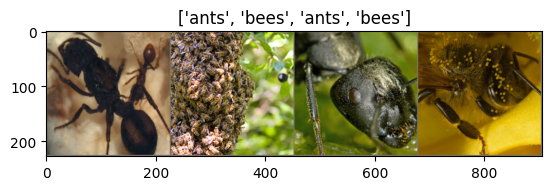

In [14]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### Finetuning the ConvNet

In [15]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

### Visualizing the model predictions

In [16]:
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from synth_mind.supervised.data import MinimalFullState
from lib.metrics import MetricsItemPlotter, MetricsCalculatorParams

class MyMetrics(MetricsItemPlotter[dict[str, None]]):
    def __init__(self, name: str, num_images=6):
        super().__init__(name=name)
        self.num_images = num_images
        self.model: torch.nn.Module | None = None

    def run(self, params: MetricsCalculatorParams) -> dict[str, None]:
        self.model = params.model
        return dict()

    def plot(self, info: MinimalFullState, metric: dict[str, None], figsize: tuple[float, float] | None) -> list[Figure]:
        model = self.model
        assert model is not None
        figs = self.visualize_model(model, figsize=figsize)
        plt.ioff()
        plt.show()
        return figs

    def visualize_model(self, model: torch.nn.Module, figsize: tuple[float, float] | None) -> list[Figure]:
        num_images = self.num_images
        was_training = model.training
        model.eval()
        images_so_far = 0
        fig = plt.figure(figsize=figsize)
        figs = [fig]

        with torch.no_grad():
            for i, (inputs, labels) in enumerate(dataloaders['val']):
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)

                for j in range(inputs.size()[0]):
                    images_so_far += 1
                    ax = plt.subplot(num_images//2, 2, images_so_far)
                    ax.axis('off')
                    ax.set_title(f'predicted: {class_names[preds[j]]}')
                    imshow(inputs.cpu().data[j])

                    if images_so_far == num_images:
                        model.train(mode=was_training)
                        return figs
                    else:
                        img = plt.gcf()
                        figs.append(img)
            model.train(mode=was_training)

        return figs

### Create the Manager

In [17]:
from synth_mind import supervised
from synth_mind.supervised.handlers import GeneralBatchExecutor, GeneralBatchAccuracyCalculator, Evaluator
from lib.metrics import MetricsListPlotter, MainMetrics, MetricsFileDirectPlotter

class MyEvaluator(Evaluator[str, None]):
    def run(self, params) -> None:
        model = params.model
        img_path = params.input
        self.visualize_model_predictions(model, img_path)

    def visualize_model_predictions(self, model: torch.nn.Module, img_path: str):
        img = Image.open(img_path)
        img: typing.Any = data.data_transforms['val'](img)
        input: torch.Tensor = img
        input = input.unsqueeze(0)
        input = input.to(device)

        outputs = model(input)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(input.cpu().data[0])

        plt.ioff()
        plt.show()

manager = supervised.Manager(
    data_params=supervised.ManagerDataParams(
        train_dataloader=dataloaders['train'],
        validation_dataloader=dataloaders['val'],
        test_dataloader=None,
    ),
    model_params=supervised.ManagerModelParams(
        model=model_ft,
        criterion=criterion,
        executor=GeneralBatchExecutor(),
        use_best=True,
    ),
    optimizer_params=supervised.ManagerOptimizerParams(
        optimizer=optimizer_ft,
        scheduler=exp_lr_scheduler,
        train_early_stopper=None,
        test_early_stopper=None,
    ),
    metrics_params=supervised.ManagerMetricsParams(
        evaluator=MyEvaluator(),
        accuracy_calculator=GeneralBatchAccuracyCalculator(),
        metrics_calculator=MetricsFileDirectPlotter(
            plotter=MetricsListPlotter(items=[
                MainMetrics(name=NAME),
                MyMetrics(name=f"{NAME}_view", num_images=6),
            ]),
            file_path=REPORT_PATH,
        ),
        batch_interval=False,
        save_every=1,
        print_every=1,
        metric_every=1,
    ),
    config=supervised.ManagerConfig(
        save_path=SAVE_PATH,
        random_seed=0,
        train_hook=None,
    ),
)

### Train and evaluate

Starting training for 25 epochs...
[end of epoch  1 (  4.0%)] [time:   0m 50.23s (-   20m 5.45s)] [val_accuracy:  95.4%, train_accuracy:  72.1%] [val_loss: 0.0421, train_loss: 0.1289]
[end of epoch  2 (  8.0%)] [time:   1m 53.72s (-  21m 47.77s)] [val_accuracy:  87.6%, train_accuracy:  70.5%] [val_loss: 0.0878, train_loss: 0.1845]
[end of epoch  3 ( 12.0%)] [time:   2m 53.17s (-   21m 9.92s)] [val_accuracy:  90.2%, train_accuracy:  80.7%] [val_loss: 0.0653, train_loss: 0.1382]
[end of epoch  4 ( 16.0%)] [time:   3m 54.23s (-  20m 29.69s)] [val_accuracy:  86.3%, train_accuracy:  86.9%] [val_loss: 0.0986, train_loss: 0.0995]
[end of epoch  5 ( 20.0%)] [time:   4m 55.25s (-  19m 41.01s)] [val_accuracy:  88.2%, train_accuracy:  80.7%] [val_loss: 0.0928, train_loss: 0.1213]
[end of epoch  6 ( 24.0%)] [time:   5m 56.34s (-  18m 48.40s)] [val_accuracy:  88.9%, train_accuracy:  85.7%] [val_loss: 0.0823, train_loss: 0.1099]
[end of epoch  7 ( 28.0%)] [time:   6m 57.94s (-  17m 54.70s)] [val_acc

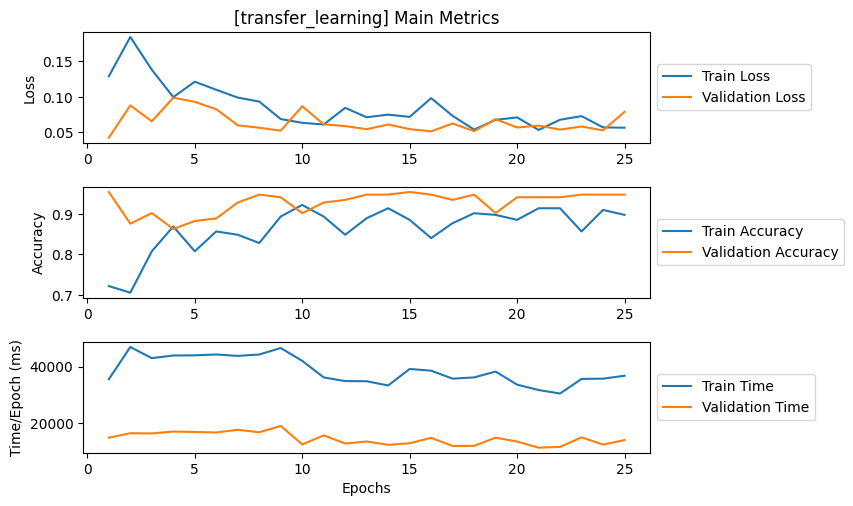

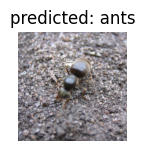

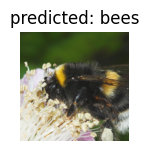

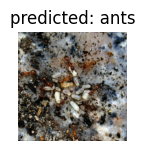

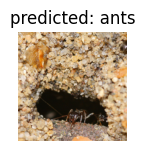

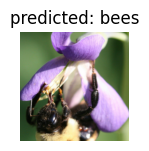

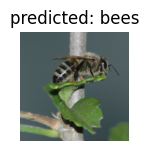

Best val Acc: 0.954248


In [18]:
manager.train(epochs=25)
info = manager.info()
assert info is not None
print(f'Best val Acc: {info.train_results.best_accuracy:4f}')

### Inference on custom images

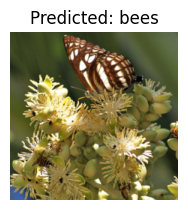

In [20]:
manager.evaluate(f'{data.data_dir}/val/bees/72100438_73de9f17af.jpg')